In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
import re
import string

# dataset
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', names=['target', 'ids', 'date', 'flag', 'user', 'text'])

# preprocessing which removes urls, user mentions, and punctuation
def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text
df['text'] = df['text'].apply(preprocess_text)

# sanity check
print(df.head())

# format 0 = negative, 1 = neutral, 2 = positive
df['target'] = df['target'].map({0: 0, 2: 1, 4: 2})

# toeknize
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
input_ids = []
attention_masks = []

for tweet in df['text']:
    encoded_dict = tokenizer.encode_plus(
                        tweet,
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# convert lists to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(df['target'])

# train test split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

# some old code, moved to the next cell for the training pipeline
# model = BertForSequenceClassification.from_pretrained(
#     "bert-base-uncased",
#     num_labels = 3,
#     output_attentions = False,
#     output_hidden_states = False,
# )
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_     A thats a bummer  You shoulda got David Car...  
1    scotthamilton  is upset that he cant update his Facebook by t...  
2         mattycus   I dived many times for the ball Managed to sa...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli   no its not behaving at all im mad why am i he...  


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset
from tqdm import tqdm, trange
import numpy as np
import os
from sklearn.metrics import classification_report
import json
from torch.optim import RMSprop

from google.colab import drive
drive.mount('/content/drive')

run_params = [128, 64, 32]

for run_num in run_params:

    # load bert
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels = 3,
        output_attentions = False,
        output_hidden_states = False,
    )

    # move to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)


    output_path = "/content/drive/MyDrive/model_save" + str(run_num)

    # define hyperparameters
    batch_size = run_num
    epochs = 1
    learning_rate = 5e-5
    epsilon = 1e-8

    # dataloader for training set
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # dataloader for validation set
    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    # optimizer
    optimizer = RMSprop(model.parameters(),
                        lr = learning_rate,
                        eps = epsilon
                    )

    # learning rate scheduler
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = 0,
                                                num_training_steps = total_steps)

    # helper function for calculating accuracy
    def flat_accuracy(preds, labels):
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        return np.sum(pred_flat == labels_flat) / len(labels_flat)

    # helper function for calculating some other metrics
    def get_metrics(preds, labels):
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        report = classification_report(labels_flat, pred_flat, output_dict=True)
        return report

    # for storing metrics
    metrics_values = []
    loss_values = []

    # defining checkpoints to evaluate and capture metrics
    checkpoint_steps = len(train_dataloader) // 25

    # training loop
    for epoch in trange(epochs, desc="Epoch"):
        # training
        total_loss = 0
        model.train()

        for step, batch in enumerate(train_dataloader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()
            outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

            loss = outputs[0]
            total_loss += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            # evaluation and save metrics and loss at each checkpoint
            if step % checkpoint_steps == 0 and not step == 0:
                avg_train_loss = total_loss / checkpoint_steps
                print("  Checkpoint Loss: {0:.2f}".format(avg_train_loss))

                model.eval()

                eval_loss, eval_accuracy = 0, 0
                predictions , true_labels = [], []

                for batch in validation_dataloader:
                    batch = tuple(t.to(device) for t in batch)
                    b_input_ids, b_input_mask, b_labels = batch

                    with torch.no_grad():
                        outputs = model(b_input_ids,
                                        token_type_ids=None,
                                        attention_mask=b_input_mask)

                    logits = outputs[0]
                    logits = logits.detach().cpu().numpy()
                    label_ids = b_labels.to('cpu').numpy()

                    predictions.append(logits)
                    true_labels.append(label_ids)

                    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
                    eval_accuracy += tmp_eval_accuracy

                metrics = get_metrics(np.concatenate(predictions, axis=0), np.concatenate(true_labels, axis=0))
                metrics['loss'] = avg_train_loss
                metrics_values.append(metrics)

                print("  Checkpoint Accuracy: {0:.2f}".format(eval_accuracy/len(validation_dataloader)))

                total_loss = 0

    # save metrics values to a file
    with open('metrics_values' + str(run_num) +  '.json', 'w') as f:
        json.dump(metrics_values, f)
    # backup in google drive as well
    with open('/content/drive/My Drive/metrics_values' + str(run_num) +  '.json', 'w') as f:
        json.dump(metrics_values, f)

    # save the model and tokenizer
    model.save_pretrained(output_path)
    tokenizer.save_pretrained(output_path)

    # clear GPU memory for the next run
    del model
    torch.cuda.empty_cache()

Mounted at /content/drive


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  Checkpoint Loss: 0.47
  Checkpoint Accuracy: 0.81
  Checkpoint Loss: 0.39
  Checkpoint Accuracy: 0.84
  Checkpoint Loss: 0.37
  Checkpoint Accuracy: 0.84
  Checkpoint Loss: 0.36
  Checkpoint Accuracy: 0.84
  Checkpoint Loss: 0.36
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.35
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.35
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.34
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.34
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.34
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.33
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.33
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.33
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.33
  Checkpoint Accuracy: 0.86
  Checkpoint Loss: 0.33
  Checkpoint Accuracy: 0.86
  Checkpoint Loss: 0.33
  Checkpoint Accuracy: 0.86
  Checkpoint Loss: 0.33
  Checkpoint Accuracy: 0.86
  Checkpoint Loss: 0.32
  Checkpoint Accuracy: 0.86
  Checkpoint Loss: 0.32
  Checkpoint Accuracy: 0.86
  Checkpoint

Epoch: 100%|██████████| 1/1 [2:10:28<00:00, 7828.54s/it]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  Checkpoint Loss: 0.45
  Checkpoint Accuracy: 0.82
  Checkpoint Loss: 0.38
  Checkpoint Accuracy: 0.82
  Checkpoint Loss: 0.37
  Checkpoint Accuracy: 0.84
  Checkpoint Loss: 0.36
  Checkpoint Accuracy: 0.84
  Checkpoint Loss: 0.36
  Checkpoint Accuracy: 0.84
  Checkpoint Loss: 0.36
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.35
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.35
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.34
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.34
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.34
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.34
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.33
  Checkpoint Accuracy: 0.86
  Checkpoint Loss: 0.33
  Checkpoint Accuracy: 0.86
  Checkpoint Loss: 0.33
  Checkpoint Accuracy: 0.86
  Checkpoint Loss: 0.33
  Checkpoint Accuracy: 0.86
  Checkpoint Loss: 0.32
  Checkpoint Accuracy: 0.86
  Checkpoint Loss: 0.32
  Checkpoint Accuracy: 0.86
  Checkpoint Loss: 0.32
  Checkpoint Accuracy: 0.86
  Checkpoint

Epoch: 100%|██████████| 1/1 [2:17:48<00:00, 8268.67s/it]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  Checkpoint Loss: 0.44
  Checkpoint Accuracy: 0.83
  Checkpoint Loss: 0.40
  Checkpoint Accuracy: 0.83
  Checkpoint Loss: 0.38
  Checkpoint Accuracy: 0.83
  Checkpoint Loss: 0.38
  Checkpoint Accuracy: 0.84
  Checkpoint Loss: 0.37
  Checkpoint Accuracy: 0.84
  Checkpoint Loss: 0.37
  Checkpoint Accuracy: 0.84
  Checkpoint Loss: 0.37
  Checkpoint Accuracy: 0.84
  Checkpoint Loss: 0.37
  Checkpoint Accuracy: 0.84
  Checkpoint Loss: 0.36
  Checkpoint Accuracy: 0.84
  Checkpoint Loss: 0.36
  Checkpoint Accuracy: 0.84
  Checkpoint Loss: 0.36
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.35


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.35
  Checkpoint Accuracy: 0.84
  Checkpoint Loss: 0.35
  Checkpoint Accuracy: 0.84
  Checkpoint Loss: 0.35
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.34
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.34
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.34
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.34
  Checkpoint Accuracy: 0.85
  Checkpoint Loss: 0.33
  Checkpoint Accuracy: 0.86
  Checkpoint Loss: 0.33
  Checkpoint Accuracy: 0.86
  Checkpoint Loss: 0.33
  Checkpoint Accuracy: 0.86
  Checkpoint Loss: 0.33
  Checkpoint Accuracy: 0.86
  Checkpoint Loss: 0.33
  Checkpoint Accuracy: 0.86


Epoch: 100%|██████████| 1/1 [2:26:31<00:00, 8791.22s/it]


In [ ]:
import os

"""This cell just saves the model locally. I added that step to the training
loop in the previous cell so it isn't being used anymore"""
output_dir = './model_save/'

# make output dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# save model and tokenizer
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

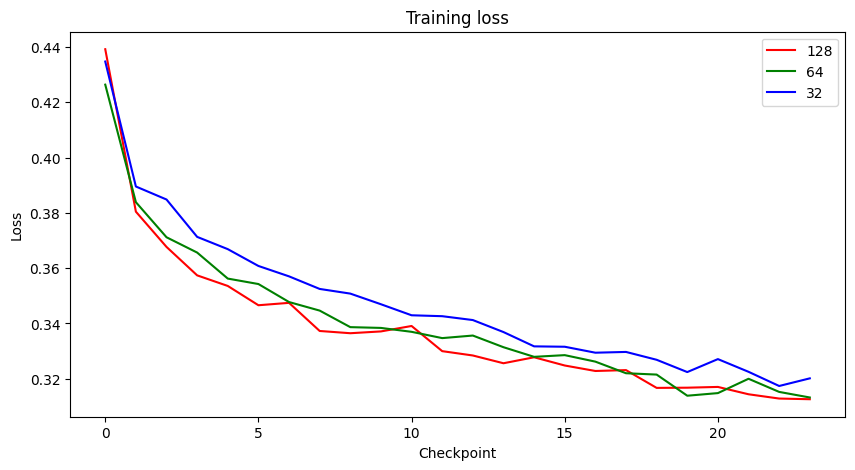

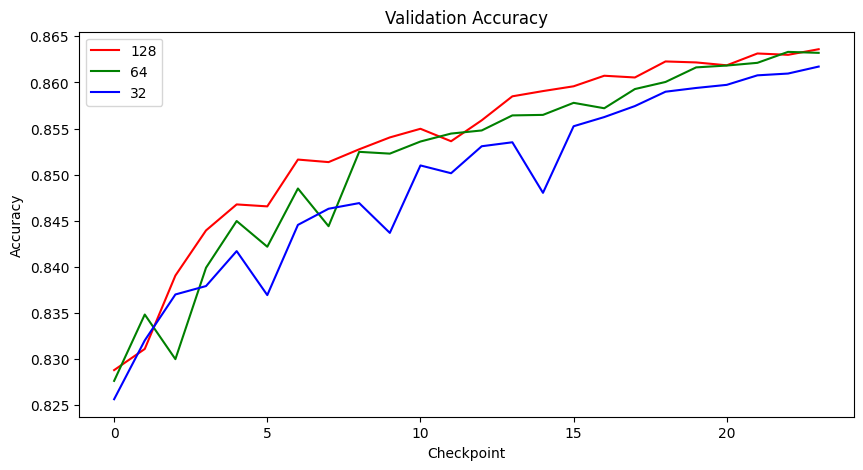

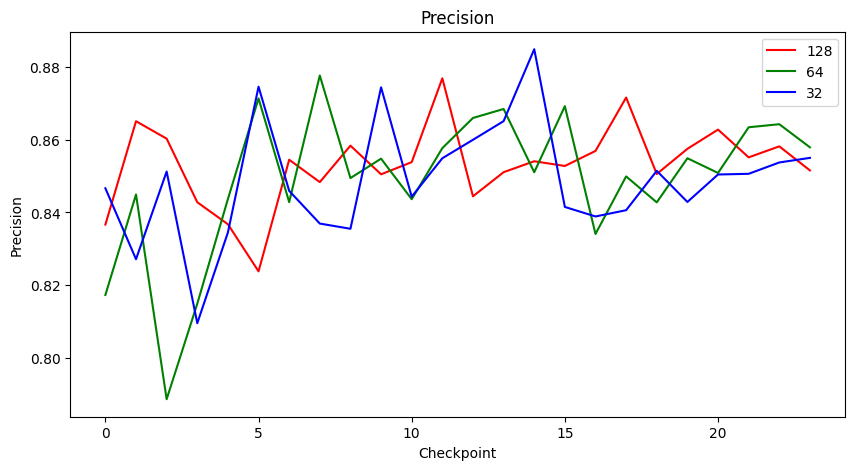

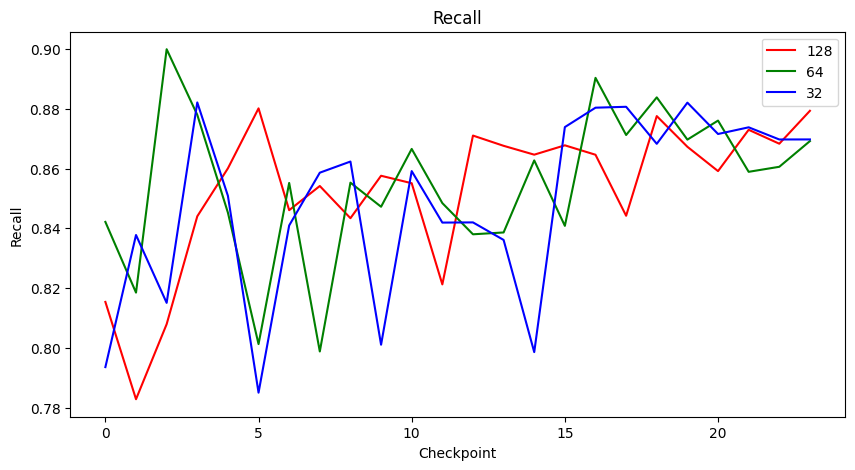

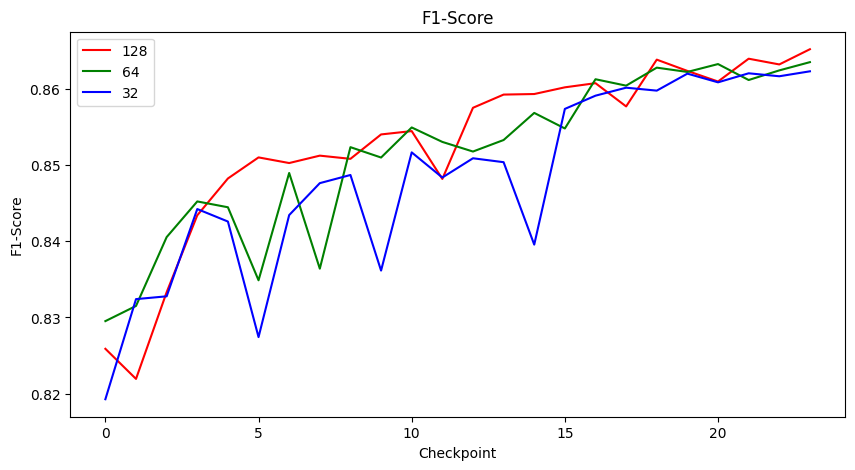

In [ ]:
import matplotlib.pyplot as plt
import json

run_nums = [128, 64, 32]
colors = ['r', 'g', 'b']
labels = ['128', '64', '32']

plt.figure(figsize=(10,5))
plt.title("Training loss")
plt.xlabel("Checkpoint")
plt.ylabel("Loss")

for run_num, color, label in zip(run_nums, colors, labels):
    with open('metrics_values' + str(run_num) +  '.json', 'r') as f:
        metrics_values = json.load(f)
    loss_values = [metrics['loss'] for metrics in metrics_values]
    plt.plot(loss_values, color=color, label=label)

plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Validation Accuracy")
plt.xlabel("Checkpoint")
plt.ylabel("Accuracy")

for run_num, color, label in zip(run_nums, colors, labels):
    with open('metrics_values' + str(run_num) +  '.json', 'r') as f:
        metrics_values = json.load(f)
    accuracy_values = [metrics['accuracy'] for metrics in metrics_values]
    plt.plot(accuracy_values, color=color, label=label)

plt.legend()
plt.show()

for metric in ['precision', 'recall', 'f1-score']:
    plt.figure(figsize=(10,5))
    plt.title(metric.title())
    plt.xlabel("Checkpoint")
    plt.ylabel(metric.title())

    for run_num, color, label in zip(run_nums, colors, labels):
        with open('metrics_values' + str(run_num) +  '.json', 'r') as f:
            metrics_values = json.load(f)
        metric_values = [metrics['0'][metric] for metrics in metrics_values]
        plt.plot(metric_values, color=color, label=label)

    plt.legend()
    plt.show()

### Evaluation of errors

In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
import pandas as pd
from sklearn.metrics import accuracy_score
import re
import string
"""This cell is for gathering a random sample of misclassified tweets to
manually evaluate"""

# read in dataset and preprocess
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', names=['target', 'ids', 'date', 'flag', 'user', 'text'])

def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['text'] = df['text'].apply(preprocess_text)

# sanity check
print(df.head())

# format 0 = negative, 1 = neutral, 2 = positive
df['target'] = df['target'].map({0: 0, 2: 1, 4: 2})

model_path = 'model'

# load in model from file
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

# move to GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

misclassified_ids = []

model.eval()

# loop that classifies every 10 tweets, then saves the id of mistakes
for i, row in df.iloc[::10, :].iterrows():
    inputs = tokenizer(row['text'], return_tensors='pt', truncation=True, padding=True).to(device)
    labels = torch.tensor([row['target']]).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(**inputs, labels=labels)

    # get predicted label
    predicted_label = torch.argmax(outputs.logits, dim=1)

    # add id to list if misclassified
    if predicted_label.item() != row['target']:
        misclassified_ids.append(row['ids'])


# save to file
misclassified_df = pd.DataFrame(misclassified_ids, columns=['ids'])
misclassified_df.to_csv('misclassified_ids.csv', index=False)

   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_     A thats a bummer  You shoulda got David Car...  
1    scotthamilton  is upset that he cant update his Facebook by t...  
2         mattycus   I dived many times for the ball Managed to sa...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli   no its not behaving at all im mad why am i he...  


In [ ]:
import pandas as pd

"""This cell grabs the content of the misclassified tweets and saves them to
a file"""
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', names=['target', 'ids', 'date', 'flag', 'user', 'text'])

file_names = ['misclassified_ids32', 'misclassified_ids64', 'misclassified_ids128']

for file_name in file_names:
    # load misclassified ids
    misclassified_df = pd.read_csv(f'{file_name}.csv')

    # find them in the dataset
    misclassified_examples = df[df['ids'].isin(misclassified_df['ids'])]

    # keep only the text and label
    misclassified_examples = misclassified_examples[['text', 'target']]

    # save to csv
    misclassified_examples.to_csv(f'examples{file_name[-2:]}.csv', index=False)

In [ ]:
from google.colab import drive
import shutil
drive.mount('/content/drive')

"""I had a problem with my colab not saving my files so I used this cell to save
them to my google drive"""

output_files = ['examples32.csv', 'examples64.csv', 'examples28.csv']

destination_folder = '/content/drive/My Drive/'

for file_name in output_files:
    shutil.move(file_name, destination_folder + file_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
